# FITTING A BOND YIELD CURVE

In this notebook I show how you can build a yield curve and fit it parametrically using a number of curve functions

In [1]:
import datetime as dt
import pandas as pd

In [2]:
from financepy.utils import *
from financepy.products.bonds import *
from financepy.market.curves import *

## Load Bond Data

In [3]:
# Move into the local folder of notebook
%pwd
%cd notebooks/products/bonds/
%pwd

[WinError 3] The system cannot find the path specified: 'notebooks/products/bonds/'
C:\Users\domok\Dropbox\Desktop\RESEARCH_DB\FinancePy\Code\financepy-git\notebooks\products\bonds


'C:\\Users\\domok\\Dropbox\\Desktop\\RESEARCH_DB\\FinancePy\\Code\\financepy-git\\notebooks\\products\\bonds'

I have downloaded some bond price data from the UK DMO

In [4]:
bond_dataframe = pd.read_csv('./data/giltbondprices.txt', sep='\t')

We'll use mid-market prices for our analysis

In [5]:
bond_dataframe['mid'] = 0.5*(bond_dataframe['bid'] + bond_dataframe['ask'])

We need to use UK bond conventions

In [6]:
dc_type, freq_type, settle_days, exDiv, calendar = get_bond_market_conventions(BondMarkets.UNITED_KINGDOM)

In [7]:
today = Date(18,9,2012)
settle_dt = today.add_weekdays(settle_days)
print("Settles:", settle_dt)

Settles: 19-SEP-2012


In [8]:
bonds = []
ylds = []

In [9]:
for index, bond in bond_dataframe.iterrows():

    date_string = bond['maturity']
    mat_date_time = dt.datetime.strptime(date_string, '%d-%b-%y')
    maturity_dt = from_datetime(mat_date_time)
    issue_dt = Date(maturity_dt.d, maturity_dt.m, 2000)
    coupon = bond['coupon']/100.0
    clean_price = bond['mid']
    bond = Bond(issue_dt, maturity_dt, coupon, freq_type, dc_type)
    yld = bond.yield_to_maturity(settle_dt, clean_price)
    bonds.append(bond)
    ylds.append(yld)

## Yield Curve Fitting

### Cubic Polynomial Curve

We can fit the yields to a polynomial. The default is a cubic so no argument is needed. 

In [10]:
curveFunction = CurveFitPolynomial()

In [11]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

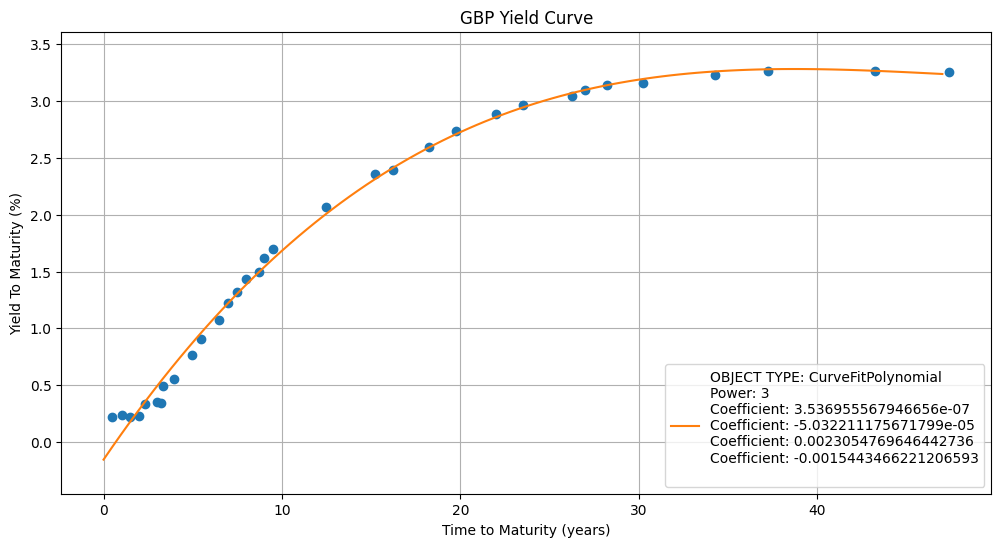

In [12]:
fitted_curve.plot("GBP Yield Curve")

We can get the coefficients as follows

In [13]:
curveFunction.coeffs

array([ 3.53695557e-07, -5.03221118e-05,  2.30547696e-03, -1.54434662e-03])

These coefficients start with the highest power of the time to maturity and end with the constant 

To get a specific yield we can call the function interp_yield

In [14]:
fitted_curve.interp_yield(20.0)*100

np.float64(2.726591242243494)

In [15]:
times = np.linspace(0,10,10)

In [16]:
fitted_curve.interp_yield(times)*100

array([-0.15443466,  0.09556536,  0.33343127,  0.55945419,  0.77392521,
        0.97713545,  1.16937602,  1.35093802,  1.52211256,  1.68319074])

### Quintic Polynomial

We can add more parameters using a Quintic polynomial.

In [17]:
curveFunction = CurveFitPolynomial(5)

In [18]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

In [19]:
curveFunction.coeffs

array([-1.44771564e-09,  1.78395761e-07, -7.41468364e-06,  9.06223223e-05,
        1.35360703e-03,  4.16055803e-07])

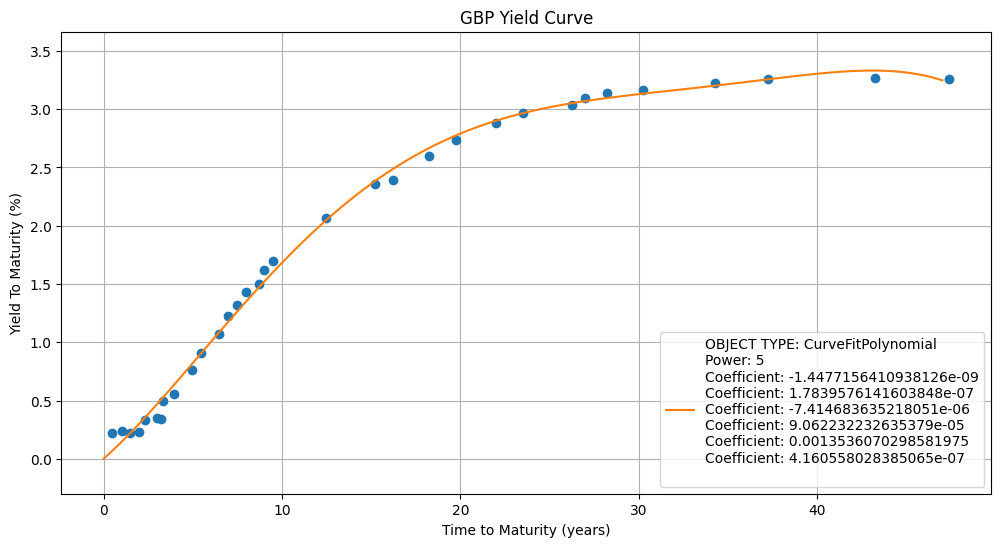

In [20]:
fitted_curve.plot("GBP Yield Curve")

The fit is slightly better.

Vectorisation works

In [21]:
fitted_curve.interp_yield(times)*100

array([4.16055803e-05, 1.60640169e-01, 3.37885305e-01, 5.26616467e-01,
       7.22266839e-01, 9.20833909e-01, 1.11885005e+00, 1.31335310e+00,
       1.50185695e+00, 1.68232210e+00])

### Nelson-Siegel Parametric Curve

We can fit the bond yields using the Nelson-Siegel curve

In [22]:
curveFunction = CurveFitNelsonSiegel()

In [23]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

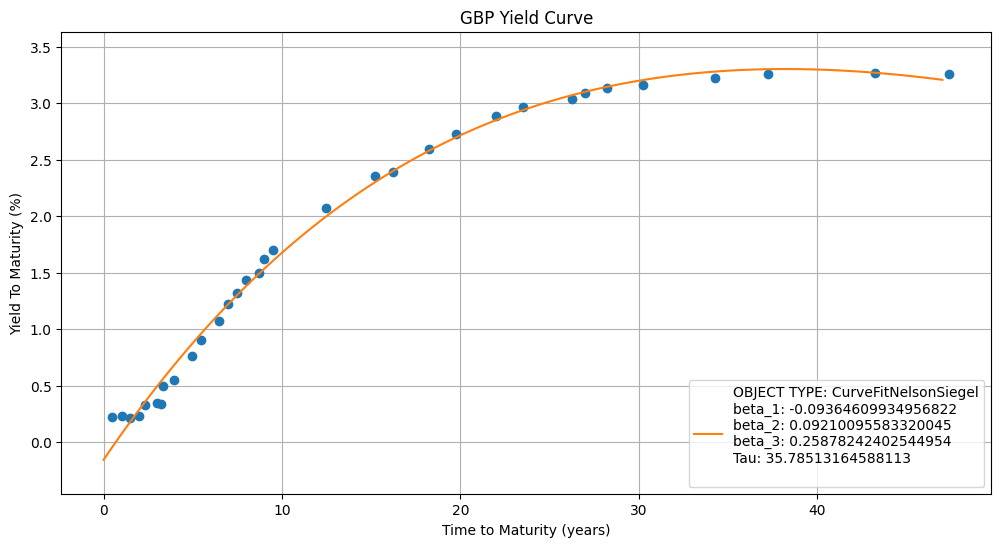

In [24]:
fitted_curve.plot("GBP Yield Curve")

We can access the underlying Nelson-Siegel parameters

In [25]:
print("beta_1 %12.8f"% curveFunction.beta_1)
print("beta_2 %12.8f"% curveFunction.beta_2)
print("beta_3 %12.8f"% curveFunction.beta_3)
print("tau   %12.8f"% curveFunction.tau)

beta_1  -0.09364610
beta_2   0.09210096
beta_3   0.25878242
tau    35.78513165


Vectorisation works

In [26]:
fitted_curve.interp_yield(times)*100

array([-0.15483231,  0.09750293,  0.33634958,  0.56251208,  0.77646047,
        0.97864893,  1.16951628,  1.34948646,  1.51896905,  1.6783597 ])

### Nelson-Siegel-Svensson Parametric Curve

There are two more parameters in this parametric curve.

In [27]:
curveFunction = CurveFitNelsonSiegelSvensson()

In [28]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

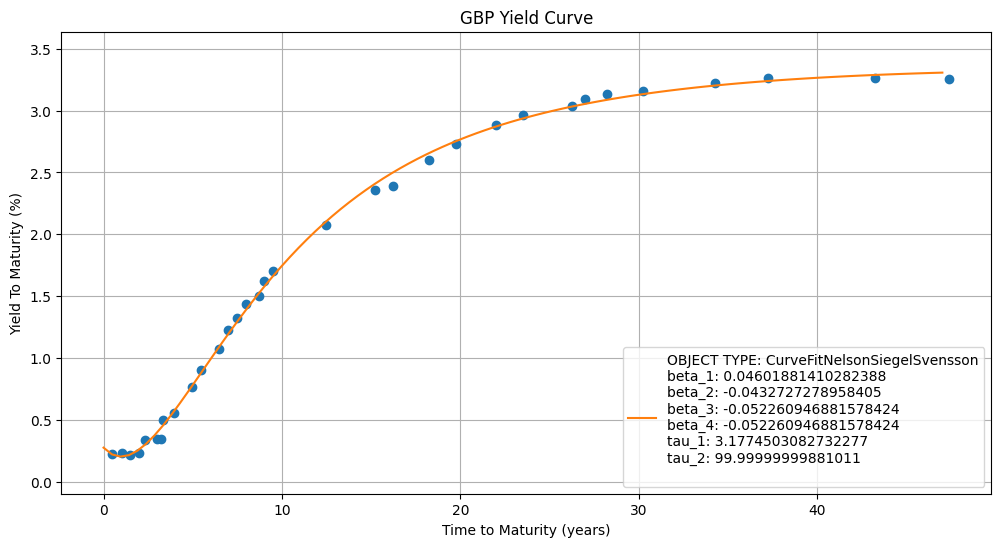

In [29]:
fitted_curve.plot("GBP Yield Curve")

Once again we can access the parameters

In [30]:
print("beta_1 %12.8f"% curveFunction.beta_1)
print("beta_2 %12.8f"% curveFunction.beta_2)
print("beta_3 %12.8f"% curveFunction.beta_3)
print("beta_4 %12.8f"% curveFunction.beta_4)
print("tau_1  %12.8f"% curveFunction.tau_1)
print("tau_2  %12.8f"% curveFunction.tau_2)

beta_1   0.04601881
beta_2  -0.04327273
beta_3  -0.05226095
beta_4  -0.03756487
tau_1    3.17745031
tau_2  100.00000000


Internally I have imposed a bound of [1,100] on tau_2. I can override this. This is what is used internally.

In [31]:
bounds = [(0, -1, -1, -1, 0, 1), (1, 1, 1, 1, 10, 100)]

I change it to

In [32]:
bounds = [(0, -1, -1, -1, 0, 1), (1, 1, 1, 1, 10, 1000)]

In [33]:
curveFunction = CurveFitNelsonSiegelSvensson(bounds=bounds)

In [34]:
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

In [35]:
print("beta_1 %12.8f"% curveFunction.beta_1)
print("beta_2 %12.8f"% curveFunction.beta_2)
print("beta_3 %12.8f"% curveFunction.beta_3)
print("beta_4 %12.8f"% curveFunction.beta_4)
print("tau_1  %12.8f"% curveFunction.tau_1)
print("tau_2  %12.8f"% curveFunction.tau_2)

beta_1   0.04430036
beta_2  -0.04153517
beta_3  -0.05107469
beta_4  -0.22564850
tau_1    3.13419138
tau_2  999.99999996


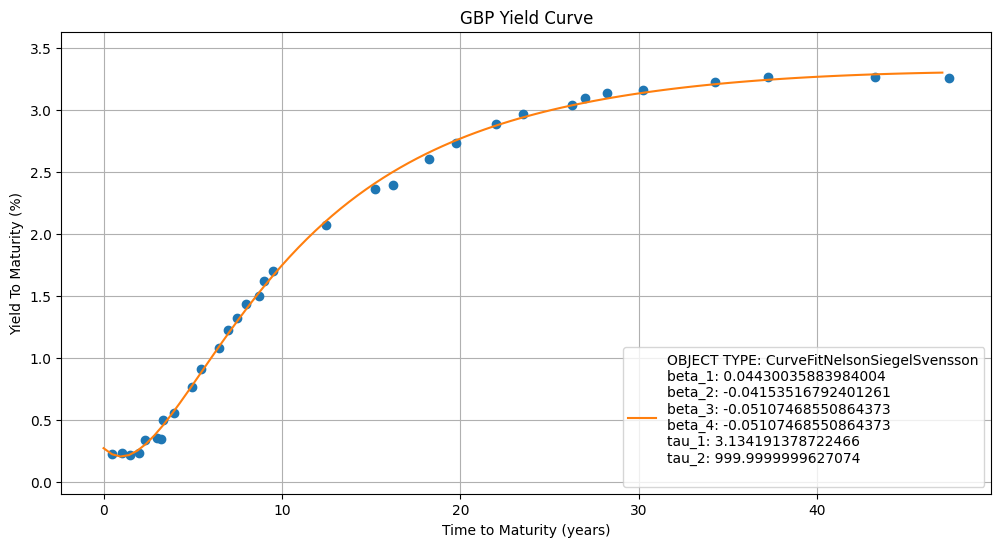

In [36]:
fitted_curve.plot("GBP Yield Curve")

It is clear that the parameter tau_2 wants to head to infinity - reducing to the Nelson-Siegel parametrisation.

Vectorisation works

In [37]:
fitted_curve.interp_yield(times)*100

array([0.26950612, 0.20311564, 0.28484317, 0.45424329, 0.66787297,
       0.89835088, 1.12894742, 1.34992082, 1.5560488 , 1.74497625])

### B-Splines

Splines give us more flexibility and ensure smoothness. Internally I put knots at 1, 3, 5 and 10 years. 

In [38]:
curveFunction = CurveFitBSpline()
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)

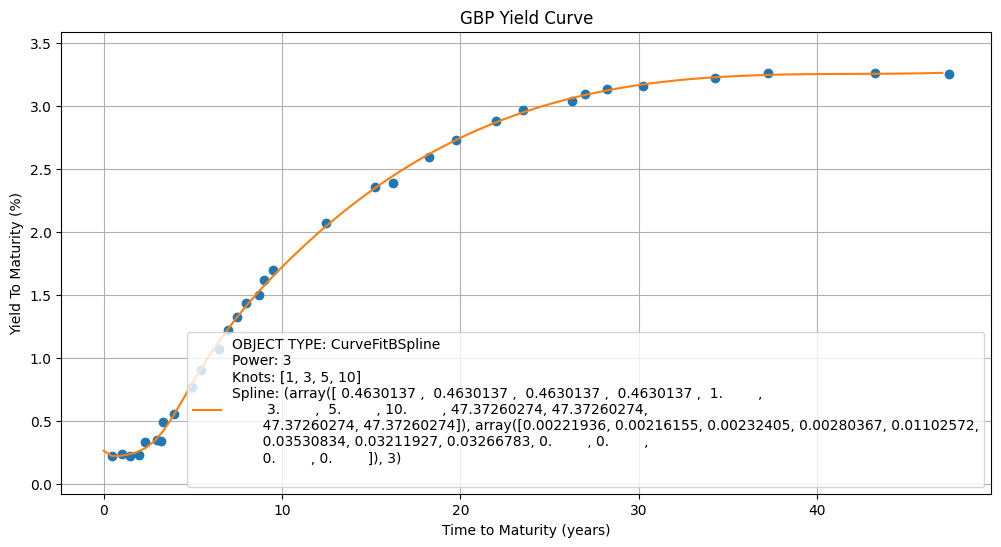

In [39]:
fitted_curve.plot("GBP Yield Curve")

We can recover the parameters of the spline.

In [40]:
curveFunction.spline

(array([ 0.4630137 ,  0.4630137 ,  0.4630137 ,  0.4630137 ,  1.        ,
         3.        ,  5.        , 10.        , 47.37260274, 47.37260274,
        47.37260274, 47.37260274]),
 array([0.00221936, 0.00216155, 0.00232405, 0.00280367, 0.01102572,
        0.03530834, 0.03211927, 0.03266783, 0.        , 0.        ,
        0.        , 0.        ]),
 3)

Vectorisation works.

In [41]:
fitted_curve.interp_yield(times)*100

array([0.26306558, 0.22601011, 0.27452422, 0.41837693, 0.67008949,
       0.9376712 , 1.1718964 , 1.37665168, 1.55813289, 1.72253585])

You can change the power of the spline

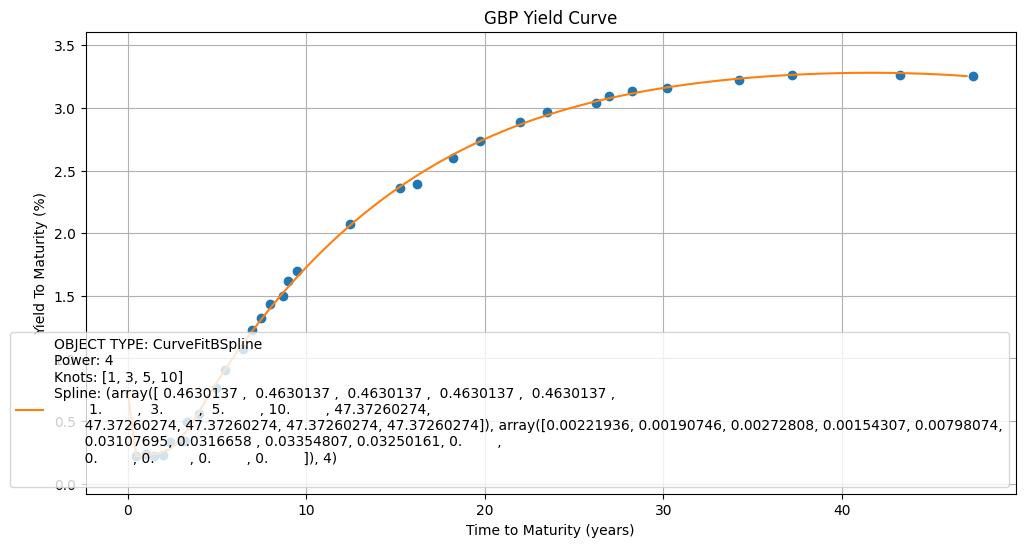

In [42]:
curveFunction = CurveFitBSpline(4)
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)
fitted_curve.plot("GBP Yield Curve")

This may not be what you want ! Let's see if 5 is better.

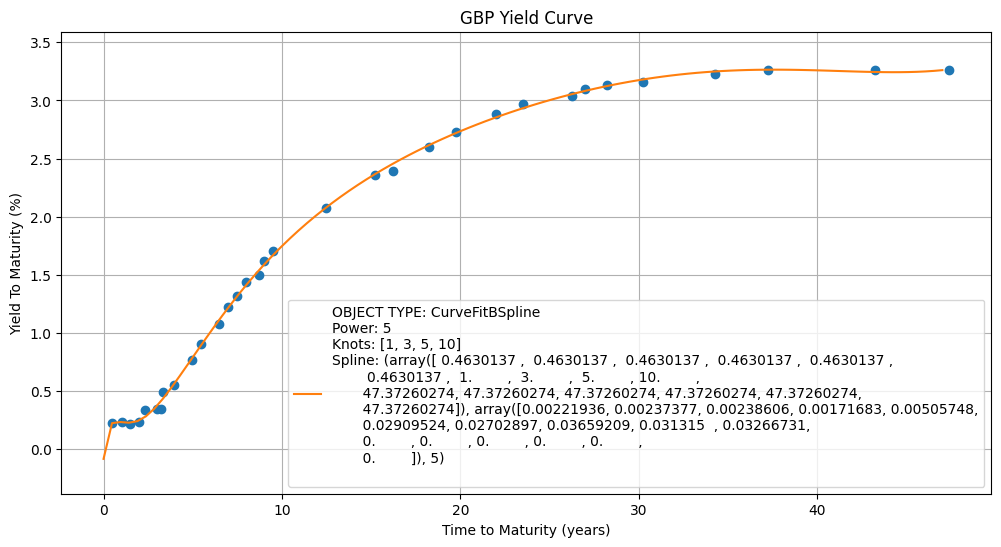

In [43]:
curveFunction = CurveFitBSpline(5)
fitted_curve = BondYieldCurve(settle_dt, bonds, ylds, curveFunction)
fitted_curve.plot("GBP Yield Curve")

Probably best to stick with a cubic B-spline.

## Inspecting the curve object


For each curve type you can examine the inner details of the calibration

In [44]:
fitted_curve.curve_fit.knots

[1, 3, 5, 10]

In [45]:
fitted_curve.curve_fit.power

5

In [46]:
fitted_curve.curve_fit.spline

(array([ 0.4630137 ,  0.4630137 ,  0.4630137 ,  0.4630137 ,  0.4630137 ,
         0.4630137 ,  1.        ,  3.        ,  5.        , 10.        ,
        47.37260274, 47.37260274, 47.37260274, 47.37260274, 47.37260274,
        47.37260274]),
 array([0.00221936, 0.00237377, 0.00238606, 0.00171683, 0.00505748,
        0.02909524, 0.02702897, 0.03659209, 0.031315  , 0.03266731,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 5)

Copyright (c) 2019, Dominic O'Kane 